In [41]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import time
import IPython

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/Colab Notebooks/Seam Carving'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Seam Carving


In [69]:
from numpy.core.numeric import convolve
def image_reader(name, downscale=1, covnvert_color=True):

  raw_img = cv2.imread(name)

  # convert colors to RGB to show images in pyplot 
  if covnvert_color:
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

  size = (int(raw_img.shape[1]*downscale), int(raw_img.shape[0]*downscale))
  img = cv2.resize(raw_img, size)

  print(f'Raw image size: {raw_img.shape[:2]}')
  print(f'Rescaled image size: {img.shape[:2]}')

  return img, raw_img

In [70]:
img, raw_img = image_reader('mountain.jpg', 0.3)

Raw image size: (1796, 2584)
Rescaled image size: (538, 775)


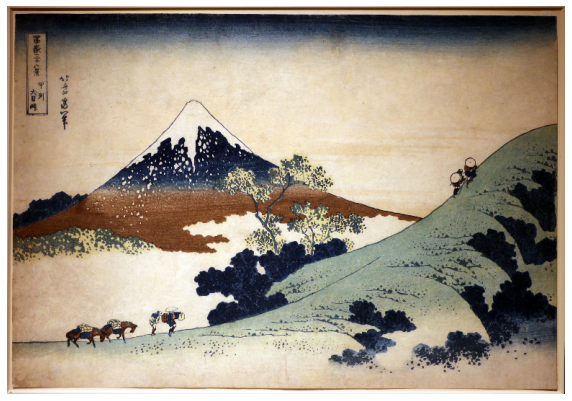

In [65]:
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(img);

In [55]:
def flowDP(arr):
    # calculate the minimal weight path to each pixel
    # row by row using DP approach
    
    nrows = arr.shape[0]
    ncols = arr.shape[1]
    
    # initialize the array for DP calculation
    # first and last column are inf to mark the borders of the image
    res = np.zeros((nrows, ncols + 2))
    res[:, 0] = np.inf
    res[:, ncols+1] = np.inf
        

    res[0, 1:ncols+1] = arr[0]
    
    # recursively calculate shortest cumulative path to each cell row by row
    for i in range(1, nrows):
        for j in range(1, ncols+1):
            # note: initial array has j-index shifted by one to the left
            res[i, j] = arr[i, j-1] + np.min([res[i-1, j-1], res[i-1, j], res[i-1, j+1]])
            
    return res[:, 1:ncols+1]

def shortestpath(flow):
    # trace back the indices of the shortest path
    # given the length of the shortest path to each cell
    
    nrows = flow.shape[0]
    ncols = flow.shape[1]
    
    # create the augmented "flow" by adding the infinite
    # border columns
    flow_aug = np.zeros((nrows, ncols + 2))
    flow_aug[:, 0] = np.inf
    flow_aug[:, ncols+1] = np.inf  
    flow_aug[:, 1: ncols+1] = flow
    
    route = [np.argmin(flow_aug[nrows-1,:])]
    
    # iteratively trace the path upwards 
    for i in range(nrows-2, -1, -1):
        col = route[-1]
        
    # the path comes to the pixel from one of three above it
        route.append(col - 1 + np.argmin([
            flow_aug[i, col-1],
            flow_aug[i, col],
            flow_aug[i, col+1]
        ]))
    
    return np.array(route[::-1]) - 1

def laplasian_energy(img):
    
    # laplacian-based energy function of image     

    img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    lap = cv2.Laplacian(img_mono, cv2.CV_64F, ksize=3)
    lap = np.uint8(np.abs(lap))
    
    return lap
    
def gradient_energy_conv(img):
    
    # gradient-based (Sobel operator) energy function of image 

    img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    grad_x = cv2.Sobel(img_mono, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img_mono, cv2.CV_64F, 0, 1, ksize=3)

    grad = np.abs(grad_x) + np.abs(grad_y) # l1-norm originally used in the artile
#     grad = np.sqrt(grad_x**2 + grad_y**2) # l2-norm
    
    return grad
    
def seam_carve(original_img, *, n_iter=None, frac=0.3, energy_func=gradient_energy_conv, 
               spt_calulator=flowDP, axis=1, save_animation=False, save_path='animation/'):
    
    out = display(IPython.display.Pretty('Starting...'), display_id=True)
    
    img = original_img.copy()
    
    if not n_iter:
        n_iter = int(frac*img.shape[axis])
        
    if axis == 0:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        
    # an array to store the history of seam deletion
    del_map = np.zeros(img.shape[:2], dtype=np.int8)
        
    tic = time.time()
    ncols_orig = img.shape[0]
        
    for i in range(n_iter):
        
        energy = energy_func(img)
        flow = flowDP(energy)
        path = shortestpath(flow)
        
        nrows, ncols = energy.shape
        
        # save intermediate pictures to produce animation
        if save_animation:
            img_seam = img.copy()
            img_seam[np.arange(ncols) == np.array(path)[:, None]] = [0, 0, 255]
            img_framed = np.concatenate((img_seam, 255*np.ones((nrows, i, 3), dtype=np.uint8)), axis=1)
            cv2.imwrite(save_path + f'{2*i}.png', img_framed)    
        
        # delete the lowest-energy path from the image and mark it on the deletion map
        img = img[np.arange(ncols) != np.array(path)[:, None]].reshape(nrows,-1, 3)
        map_temp = del_map[del_map == 0].reshape(nrows,-1)
        map_temp[(np.arange(ncols) == np.array(path)[:, None])] = 1
        del_map[del_map == 0] = map_temp.flatten()
        
        if save_animation:
            img_framed = np.concatenate((img, 255*np.ones((nrows, i+1, 3), dtype=np.uint8)), axis=1)
            cv2.imwrite(save_path + f'{2*i+1}.png', img_framed)        
        
        # timer interface
        toc = time.time()
        out.update(IPython.display.Pretty(
            f'Iteration {i + 1}/{n_iter}' 
            f'\nElapsed time: {np.round((toc - tic), 1)}s,'
            f'\nEstimated time left: {np.round((toc - tic) * (n_iter / (i + 1) - 1), 1)}s,' 
            ))
        
    if axis == 0:
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        del_map = np.rot90(del_map)

    return img, del_map

def overlay_map(img, map):

  # show the deleted seams on the original image
  img_carved = img.copy()
  img_carved[del_map==1] = [0, 0, 255]

  return img_carved

In [72]:
sc, del_map = seam_carve(img, energy_func=gradient_energy_conv, n_iter=100)

Iteration 100/100
Elapsed time: 279.2s,
Estimated time left: 0.0s,

In [56]:
img_carved = overlay_map(img, del_map)

In [25]:
del_map.shape

(538, 775)

In [57]:
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(img);

Output hidden; open in https://colab.research.google.com to view.

In [68]:
img.shape

(538, 775, 4)